In [1]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
from itertools import groupby
from scipy.stats import pearsonr
from modules import estimate_yield as estimate
from bias_correction import BiasCorrection
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_absolute_percentage_error as mape 
from IPython.core.interactiveshell import InteractiveShell
import modules.provide_datasets as data

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "last_expr"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,12))
homogeneous_groups = list(range(1,5))
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]

### 1. Read Data

In [2]:
kfold_cv_dataset = pd.read_csv("data/kfold_cv_dataset.csv")
results_of_modification_steps = pd.read_csv("data/results_of_modification.csv")
observations = pd.read_csv("data/daily_observed.csv")
hindcasts = pd.read_csv("data/daily_raw_hindcasts.csv")

## 2. Simulate wheat yield

In [3]:
def perform_simulations_and_compute_metrics(df):
    rmse_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    r2_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    mape_scores = pd.DataFrame(0, index=models, columns=months_of_crop_season)
    simulations = []
    for month in months_of_crop_season:
        for model in models:
            res = estimate.kfold_cross_validation(df, model=model, init=month, no_of_features=8)
            res = res.assign(model=model, init_month=month)
            simulations.append(res)
            # rmse
            rmse_score = 100 * mse(res["yield"], res["predicted"], squared=False)/(res["yield"].mean())
            rmse_scores.loc[model, month] = np.round(rmse_score, 2)
            # coefficient of determination
            r2_score = r2(res["yield"], res["predicted"])
            r2_scores.loc[model, month] = np.round(r2_score, 2)
            # mean absolute percentage error
            mape_score = 100 * mape(res["yield"], res["predicted"])
            mape_scores.loc[model, month] = np.round(mape_score, 2)
    
    simulations = pd.concat(simulations, ignore_index=False, axis=0)    
    return (simulations, rmse_scores, r2_scores, mape_scores)

In [4]:
simulations, rmse_scores, r2_scores, mape_scores = perform_simulations_and_compute_metrics(kfold_cv_dataset)

In [5]:
#simulations.sample(2)
rmse_scores.head(5)
#r2_scores

,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,12.12,12.47,11.76,11.62,10.47,9.86,7.90,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01


### 3. Visualizations


#### 3.1 Results of modification steps

In [6]:
results_of_modification_steps.columns = ['exp', 'model', '4', '5', '6', '7', '8', '9', '10', '11']

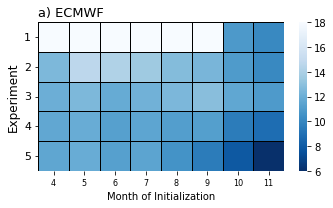

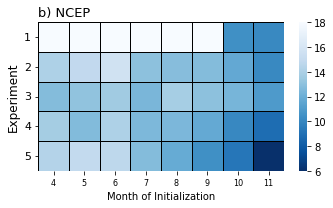

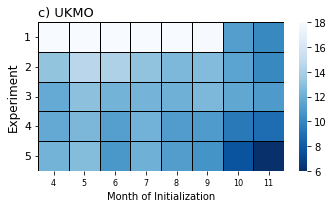

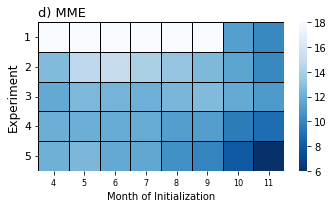

In [7]:
model_to_index = {"ECMWF":"a)", "NCEP":"b)", "UKMO":"c)", "MME":"d)"}
for model in ["ECMWF", "NCEP", "UKMO", "MME"]:
    to_plot = results_of_modification_steps.loc[(results_of_modification_steps["model"] == model)].set_index("exp").drop(columns=["model"])
    plt.figure(figsize = (5,3))
    ax = sns.heatmap(data=to_plot.round(2), annot=False, vmin=6, vmax=18, linecolor="black", linewidths=.5, fmt="g", cmap="Blues_r", annot_kws={"size":12}) # other cmap for pearson is 'mako'
    ax.set_xlabel("Month of Initialization", fontsize=10)
    ax.set_ylabel("Experiment", fontsize=12)
    ax.set_title(model_to_index[model] + " " + model, loc="left", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=11, rotation=0)
    plt.tight_layout()
    name = model + "_experiments.svg"
    #plt.savefig("images/"+name)
    plt.show();

#### 3.2 RMSE and R2 development

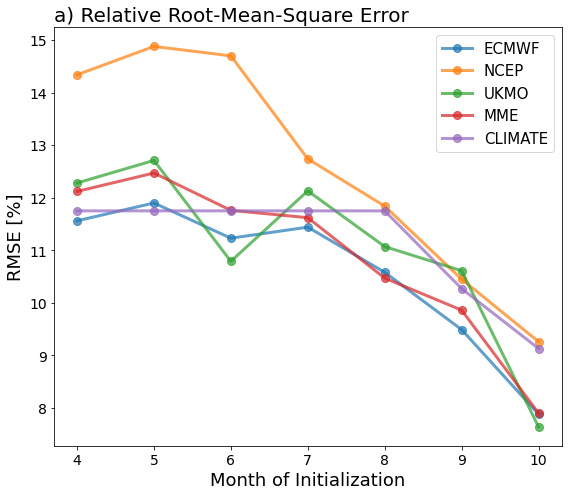

In [8]:
ax = rmse_scores.loc[rmse_scores.index != "WS", [4, 5, 6, 7, 8, 9, 10]].transpose().plot(figsize=(8,7), 
                                                                 marker='o', 
                                                                 ms=8, 
                                                                 lw=3, 
                                                                 linestyle='-', 
                                                                 alpha=.7, 
                                                                 #markerfacecolor='white',
                                                                 markeredgewidth=1, 
                                                                 legend=False)
#ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
#ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
ax.set_xlabel('Month of Initialization', fontsize=18)
#ax.set_ylabel(r'$R^{2}$', fontsize=18)
ax.set_ylabel('RMSE [%]', fontsize=18)
ax.set_title('a) Relative Root-Mean-Square Error', loc="left", fontsize=20)
#ax.set_title('b) Coefficient of Determination', loc="left", fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=15)
#ax.set_ylim(5.5, 16.5)
#ax.set_ylim(-0.85, 0.85)
plt.tight_layout()
#plt.savefig("images/rmsescore_development.svg")
plt.show();

#### 3.3 Graphical Analysis of residuals

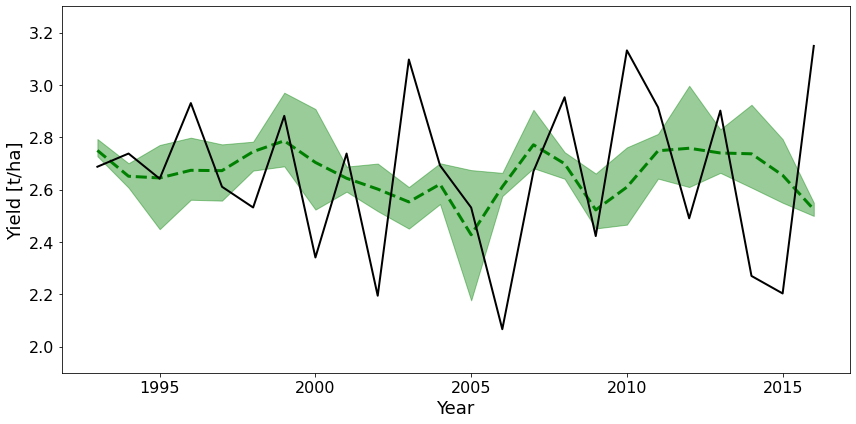

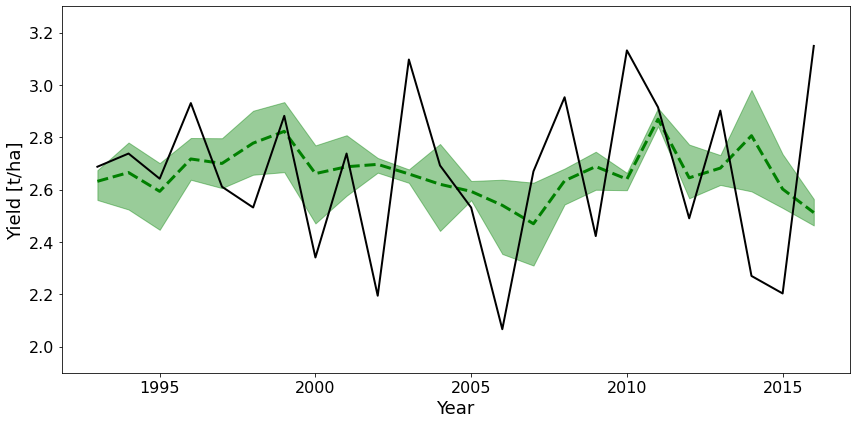

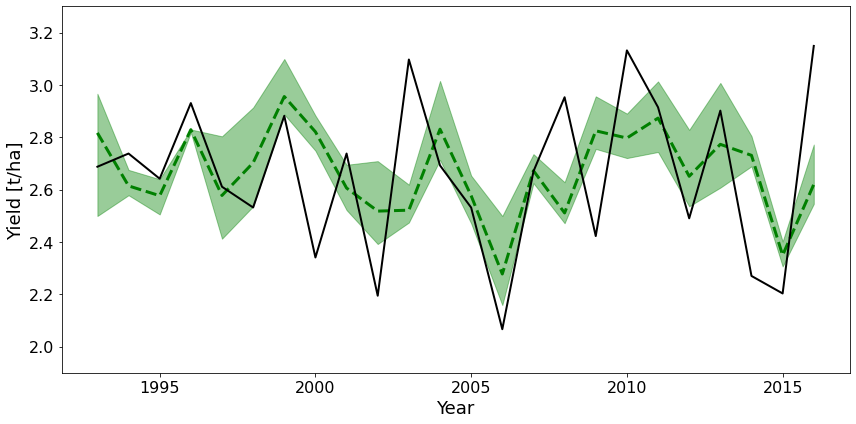

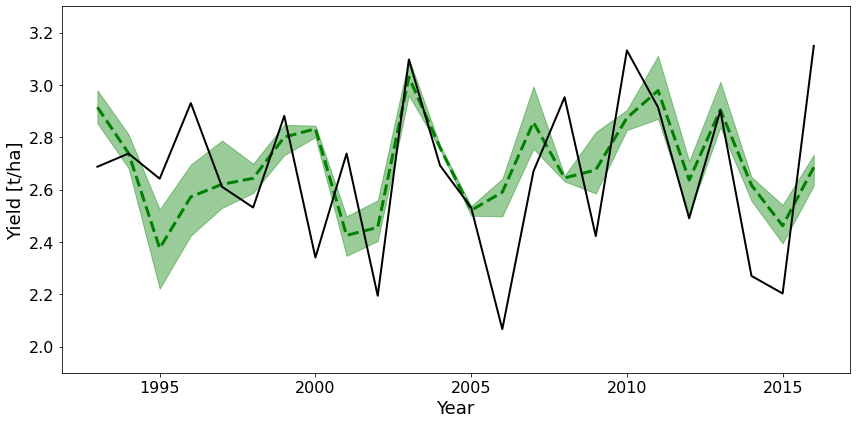

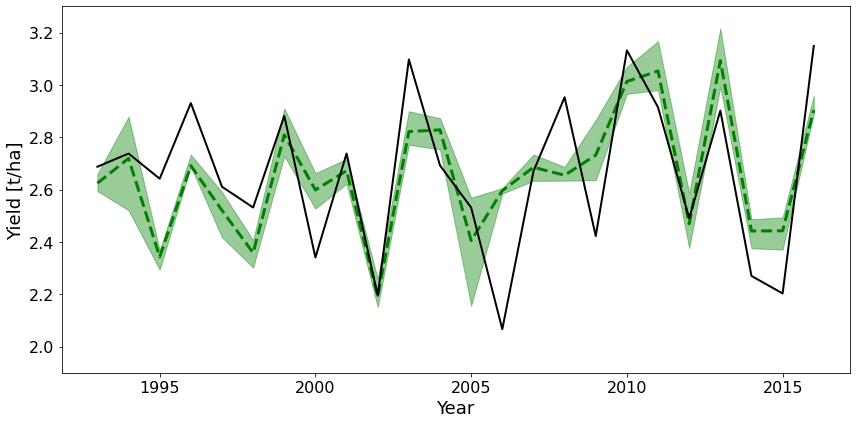

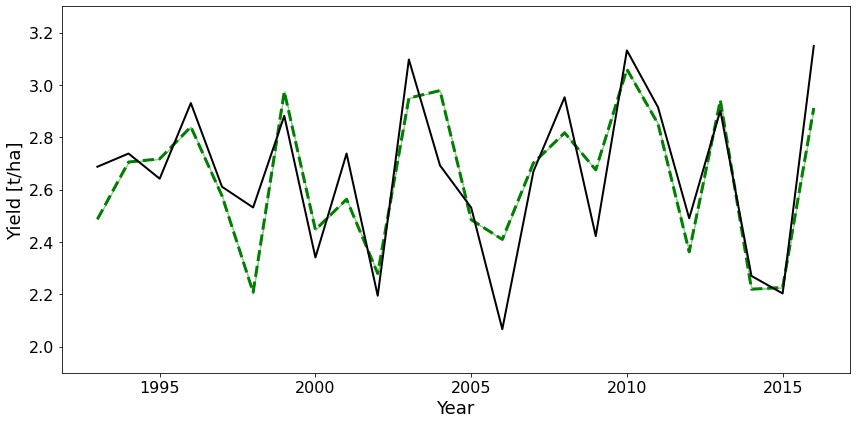

In [9]:

titles = dict(zip([6, 7, 8, 9, 10, 11], ["a) 6 (June)", "b) 7 (July)", "c) 8 (Aug)", "d) 9 (Sep)", "e) 10 (Oct)", "f) 11 (Nov)"]))
for im in list(range(6, 12)):
    #results = pd.DataFrame(0, index=models + ["OBS"], columns=list(range(1993,2017)))
    plot_sims = simulations.loc[(simulations["init_month"] == im) & (simulations["model"].isin(["MME", "ECMWF", "NCEP", "UKMO"]))].pivot(index="year", columns="model", values="predicted")
    plot_obs = simulations.iloc[:24, [0,2,3]].assign(model="OBS").pivot(index="year", columns="model", values="yield")
    plot_all = plot_sims.merge(plot_obs, on="year").apply(lambda x: x/1000)
    min_values = plot_all[["ECMWF", "NCEP", "UKMO"]].min(axis=1).values
    max_values = plot_all[["ECMWF", "NCEP", "UKMO"]].max(axis=1).values
    plt.figure(figsize=(12,6))
    
    ax = sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["MME"], linewidth=3, color="green", linestyle="--")
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["OBS"], linewidth=2, color="black", alpha=1)
    plt.fill_between(plot_all.index, min_values, max_values, color="green", alpha=0.4)
    ax.set_xlabel("Year", fontsize=18)
    ax.set_ylabel("Yield [t/ha]", fontsize=18)
    ax.set_ylim(1.9, 3.3)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    name = str(titles[im])
    plt.tight_layout()
    #plt.savefig("images/" + name + ".svg")
    plt.show()

#### 3.4 Pearson R of Climate Features

In [10]:
forecast_models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE"]
results = pd.DataFrame(0, index=list(range(0,20)), columns=list(range(6,11)) + ["model", "variable", "metric"])
results = results.assign(model=forecast_models * 4, variable=["Tmean"]*10 + ["Rain"]*10, metric=["MAE"]*5 + ["Pearson"]*5 + ["MAE"]*5 + ["Pearson"]*5)

init_month_to_relevant_columns = {
    6: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    7: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    8: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Aug_1', 'Tmean_Aug_2', 'Tmean_Aug_3', 'Tmean_Aug_4', 'Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    9: {
        "Rain": ['Rain_Sep_1', 'Rain_Sep_2', 'Rain_Sep_3', 'Rain_Sep_4'],
        "Tmean": ['Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
        },
    10: {
        "Rain": ["Rain_Aug_1"],
        "Tmean": ['Tmean_Oct_1', 'Tmean_Oct_2', 'Tmean_Oct_3', 'Tmean_Oct_4']
    }
}
for var in ["Rain", "Tmean"]:
    for im in [6, 7, 8, 9, 10]:
        for model in forecast_models:
            df_model = kfold_cv_dataset.loc[(kfold_cv_dataset["model"] == model) & (kfold_cv_dataset["init_month"] == im), init_month_to_relevant_columns[im][var]].reset_index(drop=True).copy()
            df_obs = kfold_cv_dataset.loc[(kfold_cv_dataset["model"] == "WS") & (kfold_cv_dataset["init_month"] == 11), init_month_to_relevant_columns[im][var]].reset_index(drop=True).copy()
            
            df_model = df_model.values.reshape(1, -1).flatten()
            df_obs = df_obs.values.reshape(1, -1).flatten()
            
            results.loc[(results["model"] == model) & (results["variable"] == var) & (results["metric"] == "MAE"), im] = mae(df_obs, df_model)
            results.loc[(results["model"] == model) & (results["variable"] == var) & (results["metric"] == "Pearson"), im] = pearsonr(df_obs, df_model)[0] 

results.loc[(results["variable"] == "Rain"), 10] = np.nan


                6         7         8         9        10
model                                                    
ECMWF    0.963076  0.896597  0.816186  0.933008  0.736494
NCEP     1.277030  1.142168  1.074109  1.163677  0.956836
UKMO     0.982786  1.029502  0.898655  1.108071  0.864617
MME      0.990387  0.964489  0.843377  1.025950  0.782819
CLIMATE  0.934700  0.934700  0.934700  0.948806  0.948806


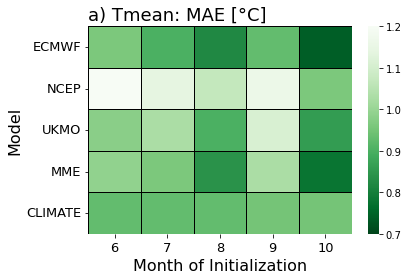

In [11]:
for m in ["MAE"]:
    for var in ["Tmean"]:
        to_plot = results.loc[(results["variable"] == var) & (results["metric"] == m), list(range(6,11))+ ["model"]].set_index("model")
        print(to_plot)
        plt.figure(figsize = (6,4))
        ax = sns.heatmap(data=to_plot.round(2), vmax=1.2, vmin=0.7, annot=False, linecolor="black", linewidths=1, fmt="g", cmap="Greens_r", annot_kws={"size":12}) # 'copper', 'Greens', 'Purples'
        ax.set_xlabel("Month of Initialization", fontsize=16)
        ax.set_ylabel("Model", fontsize=16)
        ax.set_title("a) Tmean: MAE [°C]", loc="left", fontsize=18)
        ax.xaxis.set_tick_params(labelsize=13)
        ax.yaxis.set_tick_params(labelsize=13, rotation=0)
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.7, 0.8, 0.9, 1, 1.1, 1.2])
        plt.tight_layout()
        #plt.savefig("images/tmean_mae.svg")
        plt.show();

### 3.5 Rankings of Models bei Init_Month

In [12]:
idx = pd.MultiIndex.from_product([["ECMWF", "MME", "NCEP", "UKMO"], list(range(1,5))])
idx.set_names(["model", "rank"], inplace=True)
orders = pd.DataFrame(data=0, index=idx, columns=list(range(4,11)))
for im in list(range(4,11)):
    ranking = simulations.loc[simulations["init_month"] == im].round(2).pivot(index="model", columns="year", values="predicted") - simulations.loc[simulations["init_month"] == 9].round(0).pivot(index="model", columns="year", values="yield")
    ranking = abs(ranking.loc[(ranking.index != "WS") & (ranking.index != "CLIMATE")])
    ranking = ranking.astype(float)
    ranking = np.argsort(np.argsort(ranking, axis=0), axis=0)
    ranking += 1
    ranking = ranking.unstack().reset_index().groupby(["model", 0]).count().rename(columns={"year":im})
    ranking.index.names = ["model", "rank"]
    orders = ranking.combine_first(orders)

In [13]:
orders = orders.reindex(["ECMWF", "NCEP", "UKMO", "MME"], level=0)

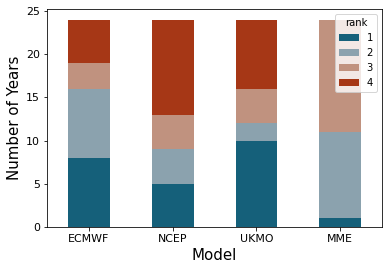

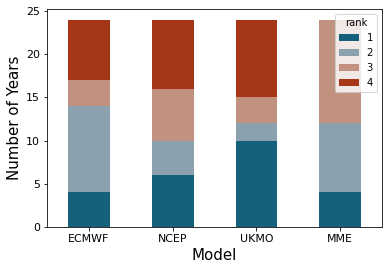

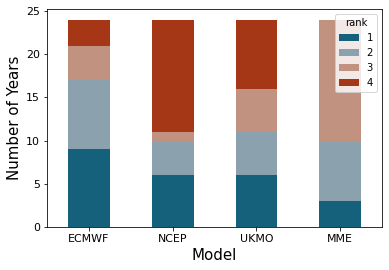

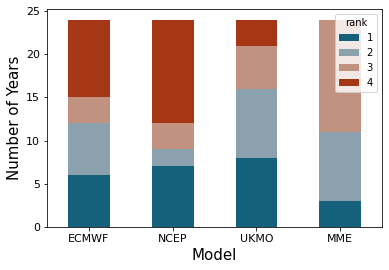

In [14]:
for im in list(range(7,11)):
    ax = orders.loc[:, im].unstack(1).plot(kind="bar",stacked=True, color=["#15607A", "#8BA2AE", "#C0927F", "#A63716"])
    ax.set_xlabel("Model", fontsize=15)
    ax.set_ylabel("Number of Years", fontsize=15)
    #ax.set_title(str(im), loc="left", fontsize=17)
    ax.xaxis.set_tick_params(labelsize=11, rotation=0)
    ax.yaxis.set_tick_params(labelsize=11, rotation=0)
    #plt.savefig("images/"+str(im) + ".svg")
    plt.show()

### 3.6 Comparison with IBGE forecasts

In [7]:
national_yield, _ = data.read_wheat_yield_data()
national_yield = national_yield.loc[national_yield["year"].isin(list(range(2006, 2017)))].reset_index(drop=True)
ibge = pd.read_excel("data/wheat/ibge_forecasts.xlsx")

In [8]:
model = (simulations
         .loc[(simulations["model"] == "MME") 
              & (simulations["init_month"].isin([10, 11])) 
              & (simulations["year"].isin(list(range(2006,2017)))), ["year", "predicted", "init_month"]]
         .reset_index(drop=True))

model = model.pivot(values="predicted", columns="init_month", index="year").reset_index()
model.columns = ["year", "oct_mme", "nov_mme"]

model = model.merge(national_yield.merge(ibge[["year", "oct_adjusted", "nov_adjusted"]], on ="year"), on="year").round(0).set_index("year")

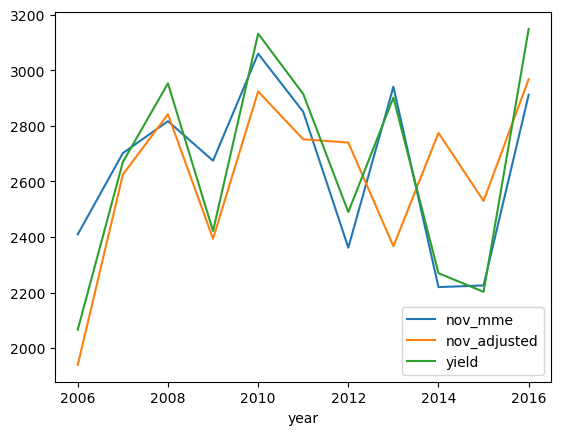

In [9]:
model[["nov_mme", "nov_adjusted", "yield"]].plot()
#plt.savefig("images/nov_ibge_mme.svg")
plt.show()

In [10]:
#r2(model["yield"], model["oct_adjusted"])
100 * mse(model["yield"], model["oct_mme"], squared=False)/(model["yield"].mean())

9.39084874862114

In [11]:
100 * mse(model["yield"], model["nov_mme"], squared=False)/(model["yield"].mean())

6.096495297892656

In [12]:
lst = ['Oct', "Nov", "Oct", "Nov"]
lst2 = ["RMSE", "RMSE", "R2", "R2"]
lst3 = [9.4, 6.1, 0.54, 0.8]
lst4 = [14.2, 10.4, -0.07, 0.43]
  
mme_vs_ibge = pd.DataFrame(list(zip(lst, lst2, lst3, lst4)),
               columns =["month", "metric", 'MME', 'IBGE'])

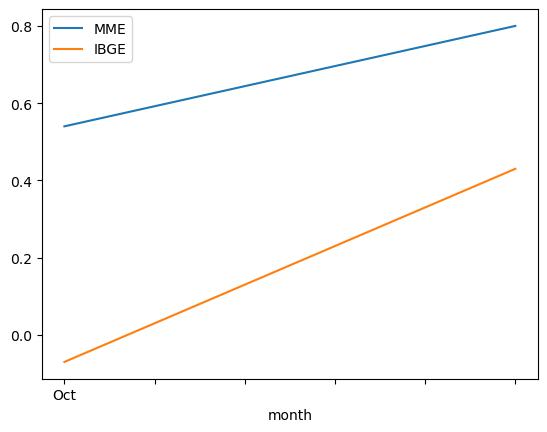

In [13]:
mme_vs_ibge.loc[mme_vs_ibge["metric"] == "R2", ["MME", "IBGE", "month"]].set_index("month").plot()
#plt.savefig("images/r2_ibge_mme.svg")
plt.show()

### 3.7 Extreme years

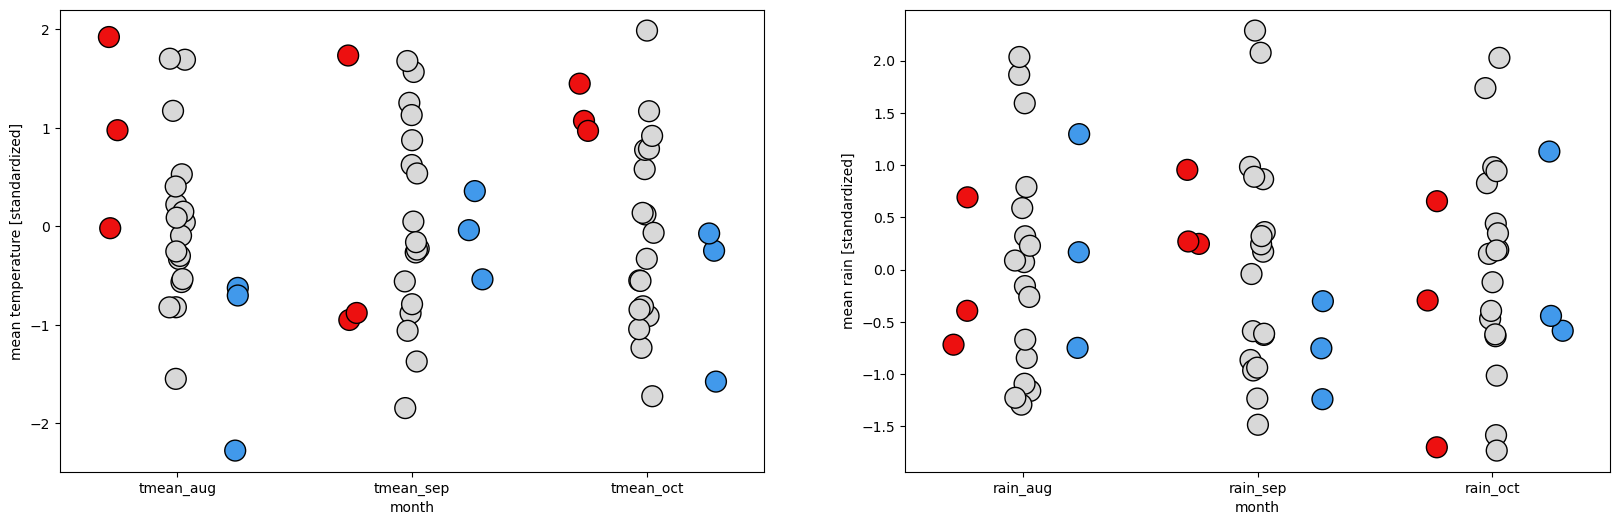

In [14]:
extreme_years = kfold_cv_dataset.loc[kfold_cv_dataset["model"].isin(["WS"]) & kfold_cv_dataset["init_month"].isin([11]), :].reset_index(drop=True)
extreme_years["tmean_aug"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Tmean_Aug" in col]].mean(axis=1)
extreme_years["tmean_sep"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Tmean_Sep" in col]].mean(axis=1)
extreme_years["tmean_oct"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Tmean_Oct" in col]].mean(axis=1)
extreme_years["rain_aug"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Rain_Aug" in col]].mean(axis=1)
extreme_years["rain_sep"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Rain_Sep" in col]].mean(axis=1)
extreme_years["rain_oct"] = extreme_years.loc[:, [col for col in extreme_years.columns if "Rain_Oct" in col]].mean(axis=1)

relevant_columns = ["tmean_aug", "tmean_sep", "tmean_oct", "rain_aug", "rain_sep", "rain_oct"]
extreme_years[relevant_columns] = (extreme_years[relevant_columns] - extreme_years[relevant_columns].mean())/extreme_years[relevant_columns].std()

extreme_years = extreme_years[["year", "yield", "tmean_aug", "tmean_sep", "tmean_oct", "rain_aug", "rain_sep", "rain_oct"]]

temp_plot = extreme_years[["tmean_aug", "tmean_sep", "tmean_oct"]].stack().reset_index()
temp_plot = extreme_years.reset_index()[["index", "year", "yield"]].merge(temp_plot, left_on="index", right_on="level_0")[["year", "yield", "level_1", 0]]
temp_plot.columns = ["year", "yield", "month", "mean temperature [standardized]"]
temp_plot["yield_category"] = pd.cut(temp_plot["yield"], bins=[0, 2210, 3000, 4000], labels=['low','normal','high'])
#temp_plot["yield_category"] = pd.qcut(temp_plot["yield"], q=[0,.15,.85, 1], labels=['low','normal','high'])

rain_plot = extreme_years[["rain_aug", "rain_sep", "rain_oct"]].stack().reset_index()
rain_plot = extreme_years.reset_index()[["index", "year", "yield"]].merge(rain_plot, left_on="index", right_on="level_0")[["year", "yield", "level_1", 0]]
rain_plot.columns = ["year", "yield", "month", "mean rain [standardized]"]
rain_plot["yield_category"] = pd.cut(rain_plot["yield"], bins=[0, 2210, 3000, 4000], labels=['low','normal','high'])
#rain_plot["yield_category"] = pd.qcut(temp_plot["yield"], q=[0,.15,.85, 1], labels=['low','normal','high'])


fig, axs = plt.subplots(1, 2, figsize=(20,6))

sns.stripplot(data=temp_plot, x="month", y="mean temperature [standardized]", hue="yield_category", jitter=0.1, dodge=True, palette=["#ED1010", "#D8D8D8", "#4199EB"], size=15, edgecolor="black", linewidth=1, legend=False, ax=axs[0]);
sns.stripplot(data=rain_plot, x="month", y="mean rain [standardized]", hue="yield_category", jitter=0.1, dodge=True, palette=["#ED1010", "#D8D8D8", "#4199EB"], size=15, edgecolor="black", linewidth=1, legend=False, ax=axs[1]);
#plt.savefig("images/rain_temp_stripplot.svg")
plt.show()

### Coefficients for extreme years

In [ ]:
vars_02 = ['Tmean_Aug_3','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Rain_Sep_2','Rain_Sep_3','Rain_Sep_4']
coeff_02 = [-37.83635561,-96.34786707,-54.49444911,1.57299603,-120.75758863,25.8634801,-77.61665453,-65.79805136]

vars_03 = ['Tmean_Aug_2','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Tmean_Oct_4','Rain_Sep_3','Rain_Sep_4']
coeff_03 = [-33.56818717,-76.56574195,-63.83830716,-7.40697512,-145.27783257,34.18787523,-73.62643775,-50.55139762]

vars_06 = ['Tmean_Aug_1','Tmean_Aug_2','Tmean_Aug_3','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Rain_Sep_3']
coeff_06 = [49.37596075,-1.31476243,-33.63995733,-133.91424412,-22.11567429,-14.30195987,-135.90222988,-109.48677503]

vars_10 = ['Tmean_Aug_2','Tmean_Aug_3','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Rain_Sep_1','Rain_Sep_3']
coeff_10 = [-74.473704,24.39241608,-75.15935654,-59.92659668,0.37661484,-105.37608961,-56.48490237,-99.89231884]

vars_15 = ['Tmean_Aug_2','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Tmean_Oct_4','Rain_Sep_3','Rain_Sep_4']
coeff_15 = [-59.96872899,-71.56628695,-59.10661556,-2.44646248,-141.41140893,32.47208709,-64.90698496,-59.58254664]

vars_16 = ['Tmean_Aug_2','Tmean_Aug_3','Tmean_Aug_4','Tmean_Oct_1','Tmean_Oct_2','Tmean_Oct_3','Tmean_Oct_4','Rain_Sep_3']
coeff_16 = [-83.39612285,28.79852518,-67.1506697,-44.80518364,13.26921313,-161.64096762,17.22082652,-102.07918623]

years = [2002, 2003, 2006, 2010, 2015, 2016]
years = [8*[x] for x in years]
vars = [vars_02, vars_03, vars_06, vars_10, vars_15, vars_16]
coeffs = [coeff_02, coeff_03, coeff_06, coeff_10, coeff_15, coeff_16]

coeff_analysis_02 = pd.DataFrame([8*[2002], vars_02, coeff_02]).transpose()
coeff_analysis_02.columns = ["year", "var_name", "coeff"]

coeff_analysis_03 = pd.DataFrame([8*[2003], vars_03, coeff_03]).transpose()
coeff_analysis_03.columns = ["year", "var_name", "coeff"]

coeff_analysis_06 = pd.DataFrame([8*[2006], vars_06, coeff_06]).transpose()
coeff_analysis_06.columns = ["year", "var_name", "coeff"]

coeff_analysis_10 = pd.DataFrame([8*[2010], vars_10, coeff_10]).transpose()
coeff_analysis_10.columns = ["year", "var_name", "coeff"]

coeff_analysis_15 = pd.DataFrame([8*[2015], vars_15, coeff_15]).transpose()
coeff_analysis_15.columns = ["year", "var_name", "coeff"]

coeff_analysis_16 = pd.DataFrame([8*[2016], vars_16, coeff_16]).transpose()
coeff_analysis_16.columns = ["year", "var_name", "coeff"]

coeff_analysis = pd.concat([coeff_analysis_02, coeff_analysis_03, coeff_analysis_06,
                            coeff_analysis_10, coeff_analysis_15, coeff_analysis_16])

coeff_analysis.pivot_table(index="year", columns="var_name", values="coeff").fillna(0).astype(int).replace(0, "-")
#coeff_analysis["var_name"] = coeff_analysis["var_name"].apply(lambda x: x[:-2])

#coeff_analysis.groupby(["year", "var_name"]).agg({"coeff":"mean"}).reset_index().pivot(index="year", columns="var_name", values="coeff").round(1)